# Recommendation Systems R5 Project
### Submitted by : Nitin Gupta
Dataset columns​ - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it. Source​ - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)  The repository has several datasets. For this case study, we are using the Electronics dataset. 
 
Please do the analysis based on steps( 1 to 8) as given below - 

**Steps**
1. Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics) 
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) 
3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) 
4. Build Popularity Recommender model. 
5. Build Collaborative Filtering model. 
6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. 
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. 
8. Summarise your insights. 
 

In [134]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
from surprise.model_selection import train_test_split # use surprise library for train_test_split
from surprise import Reader, Dataset # to import and read dataset from dataframe
from surprise import accuracy, SVD
from surprise import KNNWithMeans
from surprise.model_selection import GridSearchCV

## 1. Read and explore the given dataset. 
#### ( Rename column/add headers, plot histograms, find data characteristics) 

In [135]:
data=pd.read_csv('ratings_Electronics.csv',)

In [136]:
#Define column names as per PDF
data.columns=['userId','productId','ratings','timestamp']

In [137]:
data.head()

,userId,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


**Dataset columns** - first three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it. 

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userId       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [139]:
data=data.drop(['timestamp'],axis=1)

In [140]:
data.shape

(7824481, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000015411151748>]],
      dtype=object)

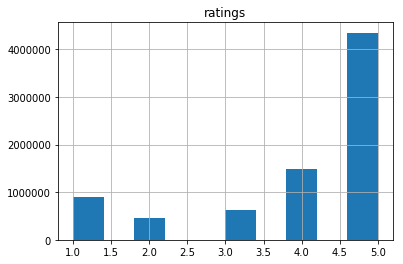

In [141]:
data.hist()

# 2. Take a subset of the dataset to make it less sparse/ denser. 
#### ( For example, keep the users only who has given 50 or more number of ratings ) 

In [142]:
# capture all users with total ratings in dataframe datar50
datar50=data.groupby(['userId']).count().sort_values('ratings',ascending=False)

In [143]:
#create new dataframe datanew holding all users who rated more than 50 times
datanew=data[data['userId'].isin((datar50.index[datar50['ratings']>50]))==True]

**Initial Data Analysis Results:**
<br>**=>** Total number of Rows - 7824481
<br>**=>** Data has 4 columns of which we have dropped timestamp column since the data seems incorrect with all timestamps converting to Year 1970.
<br>**=>** To retain only relevant data, we considered users who have more than 50 ratings
<br>**=>** The Ratings values are discrete: 1.0 , 2.0, 3.0 , 4.0 and 5.0.

# 3. Split the data randomly into train and test dataset. 
#### ( For example, split it in 70/30 ratio) 

In [144]:
datanew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122171 entries, 117 to 7824443
Data columns (total 3 columns):
userId       122171 non-null object
productId    122171 non-null object
ratings      122171 non-null float64
dtypes: float64(1), object(2)
memory usage: 3.7+ MB


In [145]:
# use surprise library for train test split
reader = Reader(rating_scale=(0, 9))
datanew1  = Dataset.load_from_df(datanew,reader)
trainset, testset = train_test_split(datanew1, test_size=.30)

# 4. Build Popularity Recommender model. 

In [146]:
# capture all products with total ratings in dataframe pdatar50
pdatar50=data.groupby(['productId']).count().sort_values('ratings',ascending=False)

In [147]:
#create new dataframe datanew holding all products who rated more than 50 times
pdatanew=data[data['productId'].isin((pdatar50.index[pdatar50['ratings']>50]))==True]

In [148]:
# check total product ratings
df_prodgroup = pdatanew.groupby(['productId']).size().reset_index(name='counts')
df_prodgroup = df_prodgroup.sort_values("counts", ascending=False)
df_prodgroup.head()

,productId,counts
18914,B0074BW614,18244
24594,B00DR0PDNE,16454
19971,B007WTAJTO,14172
6483,B0019EHU8G,12285
18260,B006GWO5WK,12226


In [149]:
# we do a grouping of the products based on their ratings. Essentially we want to identify how many ratings in each class was given 
# for each product out of the total ratings.
test = pdatanew.groupby(["productId","ratings"]).size().reset_index(name='counts')
test.shape

(126478, 3)

In [150]:
test.head()

,productId,ratings,counts
0,0972683275,1.0,32
1,0972683275,2.0,28
2,0972683275,3.0,56
3,0972683275,4.0,232
4,0972683275,5.0,703


In [151]:
## We now pivot the data to visualize the distributio of ratings across the 5 classes
df_dist = test.pivot(index='productId',columns='ratings', values='counts')
df_dist.tail(5)

ratings,1.0,2.0,3.0,4.0,5.0
productId,,,,,
B00KFAGCUM,2.0,2.0,NaN,9.0,118.0
B00KGGJPX6,2.0,NaN,3.0,8.0,41.0
B00KINSDK8,11.0,3.0,6.0,9.0,23.0
B00KWHMR6G,11.0,5.0,8.0,4.0,30.0
B00L3YHF6O,1.0,2.0,1.0,1.0,65.0


In [152]:
df_dist['productId'] = df_dist.index

In [153]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25758 entries, 0972683275 to B00L3YHF6O
Data columns (total 6 columns):
1.0          25015 non-null float64
2.0          24512 non-null float64
3.0          25447 non-null float64
4.0          25748 non-null float64
5.0          25756 non-null float64
productId    25758 non-null object
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [154]:
df_dist.columns

Index([1.0, 2.0, 3.0, 4.0, 5.0, 'productId'], dtype='object', name='ratings')

In [155]:
## Replace all NaN with 0
df_dist.fillna(0)

ratings,1.0,2.0,3.0,4.0,5.0,productId
productId,,,,,,
0972683275,32.0,28.0,56.0,232.0,703.0,0972683275
1400501466,49.0,28.0,22.0,36.0,115.0,1400501466
1400501520,9.0,2.0,6.0,8.0,57.0,1400501520
1400501776,15.0,11.0,17.0,28.0,68.0,1400501776
1400532620,35.0,12.0,11.0,27.0,86.0,1400532620
1400532655,76.0,40.0,54.0,84.0,230.0,1400532655
140053271X,57.0,37.0,31.0,73.0,233.0,140053271X
1400532736,14.0,6.0,5.0,8.0,51.0,1400532736
1400599997,55.0,14.0,20.0,33.0,100.0,1400599997


In [156]:
## matching the counts indicate that the above methods were successfull
df_dist.productId.count(),test.productId.nunique()

(25758, 25758)

In [157]:
## Scoring Formula Applied
df_dist["total"] = df_dist[1.0] + df_dist[2.0] + df_dist[3.0] + df_dist[4.0] + df_dist[5.0]
df_dist["score"] = ((df_dist[1.0] * -2) + (df_dist[2.0] * -1) + (df_dist[3.0] * 1) 
                    + (df_dist[4.0] * 2) + (df_dist[5.0] * 3))/(df_dist["total"])

## THe scoring formula can be various based on the strategy required. Above formula considers a typical user behaviour of looking at 
## how many top reviews were provided out of the reviews.


In [158]:
## Sorting the values
df_dist = df_dist.sort_values(["score"], ascending=False)

In [159]:
## Based on the score, the following Items can be considered Highly popular
df_dist.head(10)

ratings,1.0,2.0,3.0,4.0,5.0,productId,total,score
productId,,,,,,,,
B0033PRWSW,2.0,1.0,5.0,17.0,362.0,B0033PRWSW,387.0,2.894057
B007SZ0E1K,2.0,2.0,2.0,29.0,414.0,B007SZ0E1K,449.0,2.886414
B005LJQPE0,1.0,1.0,2.0,17.0,234.0,B005LJQPE0,255.0,2.882353
B006TAP096,1.0,1.0,5.0,13.0,228.0,B006TAP096,248.0,2.870968
B0043WJRRS,17.0,14.0,37.0,114.0,2330.0,B0043WJRRS,2512.0,2.869029
B001BTCSI6,2.0,1.0,2.0,12.0,200.0,B001BTCSI6,217.0,2.861751
B003RCEAB8,1.0,2.0,3.0,15.0,223.0,B003RCEAB8,244.0,2.860656
B0041OYTJE,8.0,1.0,3.0,14.0,432.0,B0041OYTJE,458.0,2.860262
B0029N3U8K,6.0,3.0,7.0,39.0,603.0,B0029N3U8K,658.0,2.855623


# 5. Build Collaborative Filtering model. 

In [160]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algoKNN = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algoKNN.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [161]:
KNNpred = algoKNN.test(testset)

In [162]:
algoSVD = SVD()
algoSVD.fit(trainset)
SVDpred = algoSVD.test(testset)

# 6. Evaluate both the models.
## (Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) 
#### You can also use a different method to evaluate the models.

In [163]:
# get RMSE for KNNMeans Model
print("Popularity based Model (KNNMeans) : Test Set")
accuracy.rmse(KNNpred, verbose=True)

Popularity based Model (KNNMeans) : Test Set
RMSE: 1.0582


1.0582487967301788

In [164]:
# get RMSE for SVD Models
print("Popularity based Model ( SVD ): Test Set")
accuracy.rmse(SVDpred, verbose=True)

Popularity based Model ( SVD ): Test Set
RMSE: 0.9807


0.9806822722629465

# 7. Get top - K ( K = 5) recommendations. 
#### Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [165]:
# Top 5 recommendations for Collaborative based on KNNMeans model
pd.DataFrame(KNNpred).sort_values('est',ascending=False).head()

,uid,iid,r_ui,est,details
25021,A2X78O6G89CB30,B001VL572I,5.0,6.661017,"{'actual_k': 1, 'was_impossible': False}"
30283,A4WEZJOIZIV4U,B004ZNA3UA,5.0,6.496993,"{'actual_k': 1, 'was_impossible': False}"
19934,A1PV5T5S4D5NPI,B00198DM2K,5.0,6.405172,"{'actual_k': 1, 'was_impossible': False}"
36209,A16SRDVPBXN69C,B000053HC5,5.0,6.278185,"{'actual_k': 1, 'was_impossible': False}"
23085,A16SRDVPBXN69C,B00007GQLS,5.0,6.275000,"{'actual_k': 1, 'was_impossible': False}"


In [166]:
# Top 5 recommendations based on SVD Model
pd.DataFrame(SVDpred).sort_values('est',ascending=False).head()

,uid,iid,r_ui,est,details
20790,A1XXMNLOLKNO0I,B0000BZL1P,5.0,5.630265,{'was_impossible': False}
14484,A23WPWLYT3P1CZ,B006W8U2MU,5.0,5.535058,{'was_impossible': False}
12117,A1KWPIORLG2QV,B00AJHDZSI,5.0,5.484085,{'was_impossible': False}
2539,A3PCEB9ND82AGE,B003ES5ZUU,5.0,5.479714,{'was_impossible': False}
20875,A28621TSIR5EOG,B007WTAJTO,5.0,5.475608,{'was_impossible': False}


In [167]:
from collections import defaultdict
## usage of defaultdict (Reference) : No Key Error even if item not there in the list
#dist_c = {}
#dist_c[2]
#dist_c = defaultdict(int)
#dist_c[2]

In [168]:
## method copied from https://surprise.readthedocs.io/en/stable/FAQ.html.
## method takes the input of Predictions (returned by surprise package predict method and returns)
## returns the top n predictions for each user.

def get_top_n(predictions, n=5):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    pred_df = pd.DataFrame()
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [169]:
## Wrapper function which internally calls the Top Recommendation method and arranges the same into a dataframe
def get_top_reco (count,test_pred):
    top_n = get_top_n(test_pred, n=count)
    pred_df = pd.DataFrame(columns=["UserId"])
    for uid, user_ratings in top_n.items():
        recommendations = {}
        reco = ""
        for (iid, _) in user_ratings:
            reco = reco + iid + ","
        dict_c={"UserId":uid,"Recommendation": reco }
        pred_df = pred_df.append(dict_c, ignore_index= True)
    return pred_df

In [170]:
## Function to use SVD algorithm and train the model generating the entire prediction data frame from the test data.
def generate_test(trainset1,testset1):
    algo = SVD(n_epochs=100, lr_all=0.005)
    algo.fit(trainset1)
        ## test with test set
    test_pred = algo.test(testset1)
    print("SVD : Test Set")
    accuracy.rmse(test_pred, verbose=True)
    return test_pred

In [171]:
## Function that takes as input USerid and 
## a) creates a train and test data set and calls function to trains the model using SVD model 
##  ,test the data (using test set) and return the all the recommendations for the Test data set 
## b) Filter  out the recommendation based on the User ID from the Test Data Set.
def find_reco(userid):
    trainset1, testset1 = train_test_split(datanew1, test_size=.30)
    test_pred = generate_test(trainset1,testset1)
    pred_out = get_top_reco (5,test_pred)
    reco = pred_out["Recommendation"][pred_out["UserId"]==userid]
    return reco

In [172]:
## Main MEthod
userid = "ALQ4USPEQ9L5N"
reco = find_reco(userid) 
print("Recommendations:" , str(reco))

SVD : Test Set
RMSE: 1.0055
Recommendations: 530    B00IVPU7DG,B00CD8ADKO,B00A7PPLP2,B00GDL2PPI,B0...
Name: Recommendation, dtype: object


# 8. Summarise your insights.

#### SUMMARY

**Initial Data Analysis Results:**
<br><br>**=>** Total number of Rows - 7824481
<br><br>**=>** Data has 4 columns of which we have dropped timestamp column since the data seems incorrect with all timestamps converting to Year 1970.
<br><br>**=>** To retain only relevant data, we considered users who have more than 50 ratings
<br><br>**=>** The Ratings values are discrete: 1.0 , 2.0, 3.0 , 4.0 and 5.0.

###### Data Exclusions:
**Popularity Based Recommender:**
    <br><br>**=>** All the Products that have less than 50 ratings for building the popularity Based Recommendation model were removed for building the Recommendation model
    <br><br>**Collaborative filter:**
    <br><br>**=>** We Removed all the Users who have rated 50 or less times in the data set
<br><br>**Recommendation (Popularity Based)**
    <br><br>**=>** For each Product distribution of ratings across 5, 4, 3, 2 and 1 was identified
    <br><br>**=>** A 5 Rating for a product indicates greater recommendation by the user and 1 Rating indicates negative recommendation.
    <br><br>**=>** Based on the above principle, we have created a scoring formula providing weightage to number of ratings across the 5 rating class and also the total number of ratings that the product received.
    Formula: [(RatingCount5 3) + (RatingCount4 2) + (RatingCount3 1) + (RatingCount2 -1) + (RatingCount1 * -2)]/[Total Rating for the Product]
    <br><br>**=>** Since its a Popularity Based Recommendation, the Recommendations donot change with Users
    <br><br>**=>** Collaborative Filtering (Matrix Factorization, Nearest Neighbours)
    <br><br>**=>** SVD was found to be providing lower RMSE and hence was chosen algorithm for building the model.
    <br><br>**=>** Both model was found to provide almost similar RMSE however SVD have slightly lower hence SVD model is more recommended model.
    <br><br>**=>** A function was created which takes UserID as input and responds back with the Recommendations (top 5) for the same based on the Model created using SVD.